In [1]:
import dionysus as d
import matplotlib.pyplot as plt

aux_zz = []
all_generator_list = []
f = []

def vertexNumber(row,colum,numCols):
    return row*numCols+colum

def addSimplexToSet (s, l):
    l.add(tuple(s))

def binaryImageToSimplicialComplexList(img):
    rowNum = img.shape[0]
    colNum = img.shape[1]
    simplices0 = set()
    simplices1 = set()
    simplices2 = set()
    for j in range(0,rowNum):
        for i in range(0,colNum):
            if (img[j,i]==255):
                v = vertexNumber(j,i,colNum)
                addSimplexToSet([v],simplices0)
                if (j < rowNum-1) and (img[j+1,i] == 255):
                    v10 = vertexNumber(j+1,i,colNum)
#                     addSimplexToSet([v10],simplices0)
                    addSimplexToSet([v,v10],simplices1)
                if (i < colNum-1) and (img[j,i+1] == 255):
                    v01 = vertexNumber(j,i+1,colNum)
#                     addSimplexToSet([v01],simplices0)
                    addSimplexToSet([v,v01],simplices1)                      
                if (i < colNum-1) and (j < rowNum-1) and (img[j+1,i+1] == 255) and (img[j+1,i] == 0) and (img[j,i+1] == 0):
                    v11 = vertexNumber(j+1,i+1,colNum)
#                     addSimplexToSet([v11],simplices0)
                    addSimplexToSet([v,v11],simplices1)
                if (i > 0) and (j < rowNum-1) and (img[j+1,i-1] == 255) and (img[j,i-1] == 0) and (img[j+1,i] == 0):
                    v1_1 = vertexNumber(j+1,i-1,colNum)
#                     addSimplexToSet([v1_1],simplices0)
                    addSimplexToSet([v,v1_1],simplices1)
                if (i < colNum-1) and (j < rowNum-1) and (img[j+1,i+1] == 255) and (img[j+1,i] == 255) and (img[j,i+1] == 255):
                    v11 = vertexNumber(j+1,i+1,colNum)
#                     addSimplexToSet([v11],simplices0)
                    addSimplexToSet([v,v11],simplices1)
#                     addSimplexToSet([v01,v11],simplices1)
#                     addSimplexToSet([v10,v11],simplices1)
                    addSimplexToSet([v,v01,v11],simplices2)
                    addSimplexToSet([v,v10,v11],simplices2)
    return simplices0,simplices1,simplices2

def binaryImageToSimplicialComplex(img):
    simplices0,simplices1,simplices2 = binaryImageToSimplicialComplexList(img)
    simplices0 = sorted(simplices0, key=lambda x: (x[0]))
    for i in range(len(simplices0)):
        simplices0[i] = list(simplices0[i])
    simplices1 = sorted(simplices1, key=lambda x: (x[0],x[1]))
    for i in range(len(simplices1)):
        simplices1[i] = list(simplices1[i])
    simplices2 = sorted(simplices2, key=lambda x: (x[0],x[1],x[2])) 
    for i in range(len(simplices2)):
        simplices2[i] = list(simplices2[i])
    return simplices0+simplices1+simplices2

def simplicesListToZigzagFiltration(slist,n):
    total_simplices_l = []
    total_simplices_set = set()
    indices_l = []
    previous_simplices_l = []
    previous_simplices_set = set()    
    slistaux = []
    aux = []
    
    for sc in slist:
        if n==0:
            aux = sorted(sc, key=lambda x: (x[0]))
        elif n==1:
            aux = sorted(sc, key=lambda x: (x[0],x[1]))
        elif n==2:
            aux = sorted(sc, key=lambda x: (x[0],x[1],x[2]))
        elif n==3:
            aux = sorted(sc, key=lambda x: (x[0],x[1],x[2],x[3]))
    
        for i in range(len(aux)):
            aux[i] = list(aux[i])
        slistaux.append(aux)        
    
    for i,sc in enumerate(slist):
        for s in slistaux[i]:
            if (tuple(s) in total_simplices_set) :
                if not (tuple(s) in previous_simplices_set):
                    index = total_simplices_l.index(s)
                    indices_l[index].append(i)          
            else:
                total_simplices_l.append(s)
                total_simplices_set.add(tuple(s))
                indices_l.append([i])
        for s in previous_simplices_l:
            if not (tuple(s) in sc):
                index = total_simplices_l.index(s)
                indices_l[index].append(i)
        previous_simplices_set = sc
        previous_simplices_l = slistaux[i]   
        
    return total_simplices_l,indices_l
       
def imageListToSimplicialComplexList (imgList):
    
    l0 = []
    l1 = []
    l2 = []
    l3 = []
    for img in imgList:
        sc0,sc1,sc2 = binaryImageToSimplicialComplexList(img)
        l0.append(sc0)
        l1.append(sc1)
        l2.append(sc2)
        l3.append(set())
        
    for r,img in enumerate(imgList):        
        rowNum = img.shape[0]
        colNum = img.shape[1]
        for j in range(0,rowNum):
            for i in range(0,colNum):
                isDiag = 0
                isCorner = 0
                if (img[j,i]==255):
                    if (i < colNum-1) and (j < rowNum-1) and (img[j+1,i+1]==255) and (img[j,i+1]==0) and (img[j+1,i]==0):
                        isDiag = 1
                        diagEdge = [vertexNumber(j,i,colNum),vertexNumber(j+1,i+1,colNum)]
                    elif (i > 0) and (j < rowNum-1) and (img[j+1,i-1] == 255) and (img[j,i-1] == 0) and (img[j+1,i] == 0):
                        isDiag = -1
                        diagEdge = [vertexNumber(j,i,colNum),vertexNumber(j+1,i-1,colNum)]
                    elif (i < colNum-1) and (j < rowNum-1) and (img[j+1,i] == 255) and (img[j,i+1] == 255) and (img[j+1,i+1] == 0):
                        isCorner = 1
                        
                    elif (i > 0) and (j < rowNum-1) and (img[j,i-1] == 255) and (img[j+1,i] == 255) and (img[j+1,i-1] == 0):
                        isCorner = -1
                        
                    if isDiag !=0 or isCorner!=0:
                        imgListAux = []
                        if (r< len(imgList)-1):
                            imgListAux.append([r+1,imgList[r+1]])
                        if (r > 0):
                            imgListAux.append([r-1,imgList[r-1]])
                        for k,img1 in imgListAux:
                            if isDiag==1 and (img1[j,i]==255) and (img1[j+1,i+1]==255) and (img1[j,i+1]==255) and (img1[j+1,i]== 0):
                                addSimplexToSet(diagEdge,l1[k])
                                addSimplexToSet([diagEdge[0],diagEdge[0]+1,diagEdge[1]],l2[k])
                                
                            elif isDiag==1 and (img1[j,i]==255) and (img1[j+1,i+1]==255) and (img1[j,i+1]==0) and (img1[j+1,i]== 255):   
                                addSimplexToSet(diagEdge,l1[k])
                                addSimplexToSet([diagEdge[0],diagEdge[1]-1,diagEdge[1]],l2[k])
                            
                            elif isDiag==-1 and (img1[j,i]==255) and (img1[j+1,i-1]==255) and (img1[j,i-1]==255) and (img1[j+1,i]== 0):
                                addSimplexToSet(diagEdge,l1[k])
                                addSimplexToSet([diagEdge[0]-1,diagEdge[0],diagEdge[1]],l2[k])
                               
                            elif isDiag==-1 and (img1[j,i]==255) and (img1[j+1,i-1]==255) and (img1[j,i-1]==0) and (img1[j+1,i]== 255):
                                addSimplexToSet(diagEdge,l1[k])
                                addSimplexToSet([diagEdge[0],diagEdge[1],diagEdge[1]+1],l2[k])

                            elif isDiag==-1 and (img1[j,i]==255) and (img1[j+1,i-1]==255) and (img1[j,i-1]==255) and (img1[j+1,i]== 255):
                                addSimplexToSet(diagEdge,l1[k])
                                addSimplexToSet([diagEdge[0]-1,diagEdge[0],diagEdge[1]],l2[k])
                                addSimplexToSet([diagEdge[0],diagEdge[1],diagEdge[1]+1],l2[k])
                                addSimplexToSet([diagEdge[0]-1,diagEdge[0],diagEdge[1],diagEdge[1]+1],l3[k])
                                
                            elif isCorner ==1 and img1[j,i]==0 and img1[j,i+1]==255 and img1[j+1,i]==255 and img1[j+1,i+1]==255:
                                diagEdge = [vertexNumber(j,i+1,colNum),vertexNumber(j+1,i,colNum)]
                                addSimplexToSet([diagEdge[0]-1],l0[k])
                                addSimplexToSet(diagEdge,l1[k])
                                addSimplexToSet([diagEdge[0]-1,diagEdge[0]],l1[k])
                                addSimplexToSet([diagEdge[0]-1,diagEdge[1]],l1[k])
                                addSimplexToSet([diagEdge[0]-1,diagEdge[0],diagEdge[1]],l2[k])
                                addSimplexToSet([diagEdge[0],diagEdge[1],diagEdge[1]+1],l2[k])
                                addSimplexToSet([diagEdge[1]+1],l0[r])
                                addSimplexToSet(diagEdge,l1[r])
                                addSimplexToSet([diagEdge[0],diagEdge[1]+1],l1[r])
                                addSimplexToSet([diagEdge[1],diagEdge[1]+1],l1[r])
                                addSimplexToSet([diagEdge[0]-1,diagEdge[0],diagEdge[1]],l2[r])
                                addSimplexToSet([diagEdge[0],diagEdge[1],diagEdge[1]+1],l2[r])
                                
                            elif isCorner ==-1 and img1[j,i]==0 and img1[j,i-1]==255 and img1[j+1,i]==255 and img1[j+1,i-1]==255:
                                diagEdge = [vertexNumber(j,i-1,colNum),vertexNumber(j+1,i,colNum)]
                                addSimplexToSet([diagEdge[0]+1],l0[k])
                                addSimplexToSet(diagEdge,l1[k])
                                addSimplexToSet([diagEdge[0],diagEdge[0]+1],l1[k])
                                addSimplexToSet([diagEdge[0]+1,diagEdge[1]],l1[k])

                                addSimplexToSet([diagEdge[0],diagEdge[0]+1,diagEdge[1]],l2[k])
                                addSimplexToSet([diagEdge[0],diagEdge[1]-1,diagEdge[1]],l2[k])
                                addSimplexToSet([diagEdge[1]-1],l0[r])
                                addSimplexToSet(diagEdge,l1[r])
                                addSimplexToSet([diagEdge[0],diagEdge[1]-1],l1[r])
                                addSimplexToSet([diagEdge[1]-1,diagEdge[1]],l1[r])
                                
                                addSimplexToSet([diagEdge[0],diagEdge[0]+1,diagEdge[1]],l2[r])
                                addSimplexToSet([diagEdge[0],diagEdge[1]-1,diagEdge[1]],l2[r])
    return l0,l1,l2,l3

def imageListToZigzagFiltration(imageList):
                                
    l0,l1,l2,l3 = imageListToSimplicialComplexList(imageList)                     
    zz_list0,zz_indices0 = simplicesListToZigzagFiltration(l0,0)
    zz_list1,zz_indices1 = simplicesListToZigzagFiltration(l1,1)
    zz_list2,zz_indices2 = simplicesListToZigzagFiltration(l2,2)
    zz_list3,zz_indices3 = simplicesListToZigzagFiltration(l3,3)
    
    simplices = zz_list0+zz_list1+zz_list2+zz_list3
    indices = zz_indices0+zz_indices1+zz_indices2+zz_indices3
    return simplices,indices

def detail(i,t,d,zz,cells):
    global aux_zz
    global all_generator_list, f
    
    aux_zz = []  
    for z in zz:
        aux_zz.append(z)        
    if len(aux_zz)!=0:
        aux_zz_last = aux_zz[len(aux_zz)-1]
    else:
        aux_zz_last = []
    z_list = []
    for x in aux_zz_last:
        z_list.append([x.element, f[cells[x.index]]])
    all_generator_list.append(z_list)    
    
def scListZigzagHomology(times):
    global aux_zz
    global all_generator_list, f
                                                    
    aux_zz = []
    all_generator_list = []

    zz, dgms, cells = d.zigzag_homology_persistence(f, times  , callback = detail)
    return dgms, all_generator_list     
        
def imageListZigzagHomology (imageList):
    global f
    
    simplices,times = imageListToZigzagFiltration(imageList)
    f = d.Filtration(simplices)
 
    return scListZigzagHomology(times)

def printGenerator (glist):
    return (' + '.join("%d * %s" % (pair[0], [v for v in pair[1]]) for pair in glist))


def plot_zigzag_bars(dgm, dimension, times, generator_list, interval_l=1, gen_l1=1, gen_l2=0, printGenerators=True,
                     order='birth', ax=None, show= True, **bar_style):
    """
    Plot the barcode.
    Arguments:
        dgm (Diagram): See for example `init_diagrams`.
    Keyword Arguments:
        order (str): How to sort the bars, either 'death' or 'birth'
                     (Default: 'birth')
        show (bool): Display the plot. (Default: False)
        ax (AxesSubplot): Axes that should be used for plotting (Default: None)
        **bar_style: Arguments passed to `ax.plot` for style of the bars.
                     (Defaults: color='b')
    """

    bar_kwargs = {'color': 'b'}
    bar_kwargs.update(bar_style)

    if order == 'death':
        generator = enumerate(sorted(dgm, key=lambda p: p.death))
    else:
        generator = enumerate(dgm)

    if ax is None:
        ax = plt.axes()

    maxi = max(times, key=max)
    maxi = maxi[len(maxi) - 1]

    ax.set_xlim(-0.5, maxi + 1.5)

    result_generators = []

    i = 0
    for j, p in generator:
        if p.death == float('inf'):
            de = maxi + 1
        else:
            de = p.death
        if de - p.birth >= interval_l:
            g = generator_list[p.data]
            if (gen_l1 <= len(g)) and (gen_l2 == 0 or len(g) <= gen_l2):
                if p.death == float('inf'):
                    ax.plot([p.birth, maxi + 1], [i, i], **bar_kwargs)
                    plt.scatter([p.birth], [i], color="blue", edgecolor="blue")
                    result_generators.append(printGenerator(generator_list[p.data]))
                    if printGenerators:
                        plt.text(p.birth, i + 0.2, printGenerator(generator_list[p.data]))
                else:
                    ax.plot([p.birth, p.death - 0.05], [i, i], **bar_kwargs)
                    plt.scatter([p.birth], [i], color="blue", edgecolor="blue")
                    plt.scatter([p.death], [i], color="white", edgecolor="blue")
                    result_generators.append(printGenerator(generator_list[p.data]))
                    if printGenerators:
                        plt.text(p.birth, i + 0.2, printGenerator(generator_list[p.data]))
                i = i + 1

    plt.text(0, i - 0.2, "Barcode of dimension " + str(dimension))
    ax.set_ylim(-1, i)
    plt.yticks(range(0,i))
    plt.xticks(range(0,maxi+2))
    labels = [i for i in range(0,maxi+2)]
    labels[maxi+1]="$+\infty$"
    ax.set_xticklabels(labels, fontsize=12)
    ax.get_xticklabels()[-1].set_fontsize(16)
    ax.set_xticklabels(labels)

    if show:
        plt.show()
        
    return len (result_generators)

def imageListZigzagPlotBar (imageList,dimensions=[0,1],interval_l=1, gen_l1=1, gen_l2=0,printGenerators=True):
    global f

    simplices,times = imageListToZigzagFiltration(imageList)
    f = d.Filtration(simplices)
    dgms, generator_list = scListZigzagHomology(times)
    
    for i in dimensions:
        dgm = dgms[i]
        plot_zigzag_bars(dgm, i, times, generator_list, interval_l, gen_l1, gen_l2,printGenerators)

## Example:

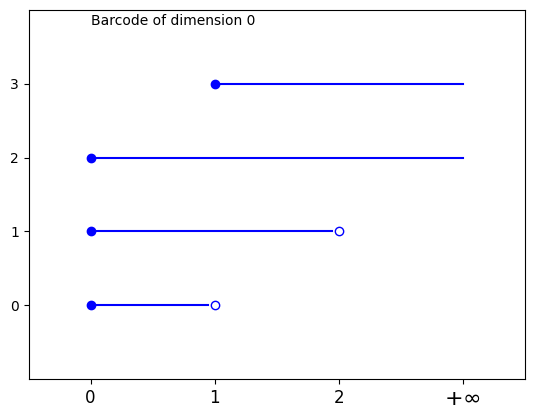

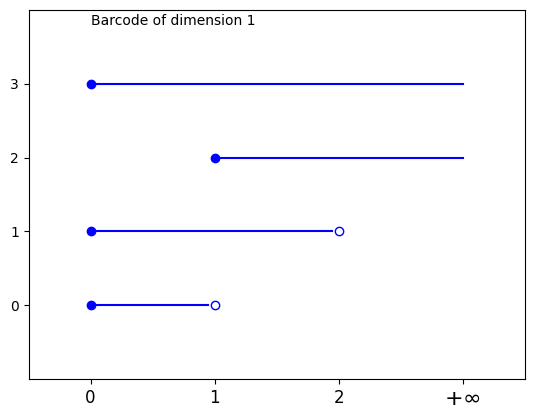

In [2]:
import cv2

img1 = cv2.imread("../examples/imagen1ByN.pbm",0)
img2 = cv2.imread("../examples/imagen2ByN.pbm",0)
img3 = cv2.imread("../examples/imagen3ByN.pbm",0)

imageListZigzagPlotBar([img1, img2, img3],dimensions=[0,1],interval_l=1,gen_l1=1,gen_l2=0,printGenerators = False)